Use Python to define computational graph, which is exectued in C++ Code.
Due to the graphical structure TF is highly parallizeable.
TF can compute gradients automatically.
The main python API is very flexible at the cost of higher complexity.
It comes with tensorboard: a visualization tool for the computational graph.

### High level APIs to Tensorflow
* `tensorflow.contrib.learn`: API compatible with scikit-learn
* `tensorflow.contrib.slim`: API to simplify computations
* `tensorflow.contrib.keras`: Keras API

### Rought Structure of Tensorflow
In principle (as e.g., in Spark) a tensorflow computation consists of two steps:
1. **Construction phase:**
 This parts specifies the computational graph. I.e., it specifies the model to compute
 In tensorflow we call the associated object _dataflow graph_ (or just graph). Any additional variable is just a node added to the graph.
 
2. **Execution phase:**
This part then runs the actual computation and returns results. 
In Tensorflow the associated object is called a _session_
### Todos / Brainstorming
* How to implement fit predict cleanly? 
* Warnings with Jupyter notebooks
* Visualization of the computational graph

### Possible Examples
* Logistic Regression
* Linear Regression
* Generalized linear models
* Survival Analysis
* Customer Livetime values
* Decision Tree
* Random Forest

# A first example

In [1]:
import tensorflow as tf

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Creating the computational graph
# Neither functions are evaluated nor variables are initialized
# Not executed yet (just like a tranformation in spark)
x = tf.Variable(3, name="x")
y = tf.Variable(5, name="y")
f = x*x*x + x + y +42

In [3]:
# A Session 1) initializes the variables + computes the graph
sess = tf.Session()
sess.run(x.initializer) # Initialize Variables
sess.run(y.initializer)
result = sess.run(f) # Run Graph
print(result)

77


In [4]:
# Convientient alternative via context
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
print(result)

77


# Initializing variables
**TF introduces shortcuts for readability:**
* `x.initializer.run()` is equivalent to `tf.get_default_session().run(x.initializer)`
* `f.eval()` is equivalent to `tf.get_default_session().run(f)` 

**Globally initializing variables**
* Instead of  initializing each  variable individually, this may be done globally.
* By calling `tf.global_variables_initializer()`
* So the above code may be written more compactly

In [5]:
init = tf.global_variables_initializer() # add init node
with tf.Session() as sess:
    init.run() # actually run init
    result = f.eval()
print(result)

77


# Using Tensorflow for experiments (jupyter notebook)
* There are several ways to:
    - speed up experimenting with TF
    - reduce boilerplates (executing sessions)
    - these are an 1) interactive tf session or 2) to enable eager execution (get rid of session calls)
### Interactive TF session
* Useful in particular for jupyter notebooks
* Don't forget to close the session afterwards (would be done automatically within the session context)

In [6]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

77


### Eager execution
* [Tensor flow documentation'](https://www.tensorflow.org/guide/eager)
* Within this execution mode TF operates similar to numpy 
* I.e, the graph is directly evaluated and thus calling the execution phase immediatly
* To this end we need to tell tensorflow
    - `tf.enable_eager_execution()`
    
**However, this operational mode is still under development!**

> Eager execution is not included in the latest release (version 1.4) of TensorFlow. To use it, you will need to build TensorFlow from source or install the nightly builds.


In [114]:
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()
x = [[2.]]
m = tf.matmul(x, x)

AttributeError: module 'tensorflow.contrib.eager' has no attribute 'enable_eager_execution'

# Graphs
* So far we did not assign any explicit graph
* The reason is that tensoflow introduces the so called **default graph**
* Any variable specified get's added to the default graph
* However, we may also introduce other graphs, apart from the default graph.

#### Graphs within jupyter notebooks
* As jupyter notebooks are used for experimenting and cells are executed various times, it is possible that the graph get's "messed up". 
* In order to clean the graph tensoflow allows to clean the graph by the command `tf.reset_default_graph()`.

In [7]:
# node is added to default graph
x1 = tf.Variable(3, "x1")
print("Is x1 in default graph?:", x1.graph is tf.get_default_graph())

# create a new graph object
my_graph = tf.Graph()
with my_graph.as_default():
    x2 = tf.Variable(30, "x2")

print("Is x2 is in my_graph?:", x2.graph is my_graph) 
print("Is x2 is in default_graph?:", x2.graph is tf.get_default_graph()) 

Is x1 in default graph?: True
Is x2 is in my_graph?: True
Is x2 is in default_graph?: False


In [8]:
x3 = tf.Variable(333, "x3") # add to default graph
tf.reset_default_graph() # reset default graph
print("Is x3 is in default graph:", x3.graph is tf.get_default_graph()) 

Is x3 is in default graph: False


# Node Lifecycle
* All node _values_ are dropped between graph runs (within a session).
* Node values are (intermediate) results
* This implies that node values are not reused (as in spark) per default.
* This leads to  inefficiencies if also intermediate results are of interest. 
* For each (intermediate) result output TF runs an individual graph run.
* In order to avoid redundant evaluations, you need to ask tensorflow to **evaluate all interesting variables within a single graph run**.
* This can be achieved by 



#### Additional Information from the textbook (A. Geron, _Hands on machine learning with scikit-learn and tensoflow_, 2017):

> All node values are dropped between graph runs, except variable values, which are maintained by the
session across graph runs (queues and readers also maintain some state, as we will see in Chapter 12). A
variable starts its life when its initializer is run, and it ends when the session is closed.

> In single-process TensorFlow, multiple sessions do not share any state, even if they reuse the same graph (each session would have its own copy of every variable). In distributed TensorFlow (see Chapter 12), variable state is stored on the servers, not in the sessions, so multiple sessions can share the same variables.

In [9]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3
# Redundant graph evaluation: 2 graphs are evaluated
with tf.Session() as sess:
    print(y.eval()) # 10
    print(z.eval()) # 15

10
15


In [10]:
# one graph computation only
with tf.Session() as sess:
    y_val, z_val =  sess.run([y, z])
    print(y_val)
    print(z_val)

10
15


# Data types

# Linear Regression - some Theory
For linear regression the closed solution is known via the so called normal equation
Todo:
1. Specify model
2. Speficy loss function
2. Write down log Likelihood function
3. Minimize + get Normal equation

### Approach 1: Non-probabilisitc using loss function
The easies approach to linear regression is to use the squared loss function, 
$$l = \sum_{i=1}^N (y_i - \hat y_i)^2,$$
where $\hat y_i$ is the predicted value and $y_i$ is the true value of sample $i$. Together with a linear, non probabilistic model for the. For feature vector $x_i$ (where the first component is per convention the constant one -aka known as intercept) the prediction is given by the linear model. In scalar product notation:
$$y_i =  x_i^T \theta,$$
with coefficient vector $\theta$. Rewriting this in Matrix notation to account for all sampels we get for the loss together with the linear model:
$$l = (Y - X\theta)^T (Y - X\theta)$$
Now we would like to find $\theta^*$ that _minimizes_ the loss. 
Setting the derivative w.r.t. $\theta$ of the loss function zero  gives the normal equation 
$$X^T(Y - X\theta) = 0.$$
If $X^T X$ is non-singular (this is the case when there are more traning examples than features because then $X^T X$ is positive definite) allows for finding the unique solutions of the normal equation, 

$$\theta ^* =  \left( X^T X  \right)^{-1} X^T Y$$

Note that this approach is non-probabilistic and thus, does not explicitly account for uncertainty  (as a probability distributions) in the data and coefficients.
### Approach 2: Probabilistic  +  generative approach using max likelihood
This approach introduces a probability distribution but does not explicitly consider a loss function. The  response is modelled  via a Normal distribution ("Gauss error") assuming constant standard deviation
$$y_i = x_i^T \theta + \epsilon := \mathcal N (x_i^T \theta, \sigma^2)$$
In other words, the conditional distribtion  $p(y \mid x, \theta, \sigma^2)$ is given by a Normal distribtion.
The likelihood function is just the pdf of __all__ datapoints assuming i.i.d (this assumption in fact leads to the factorization), 
$$\mathcal L = \Pi_{i=1}^N p(y_i \mid x, \theta, \sigma).$$
As we are aiming to optimize $\theta$ in a way, a striclty monotonic transformation is applied on the likelihood function. It leaves the optimum invariant. The standard procedure is thus to consider the the logarithm ot likelihood function:
$$\mathcal L_l = \sum_{i=1}^N \log p(y_i \mid x, \theta, \sigma).$$
Evaluating this expression for the Normal distribution gives
$$\mathcal L_l =  - \frac{1}{2\sigma^2}\sum_{i=1}^N (y_i - x_i^T \theta)^2  - \frac{N}{2}log(2\pi\sigma^2) $$
Now, we would like to _maximise_ the likelihood and thus the log likelihood with respect to $\theta$. This is equivalent to _minimizing_ the negative of it. Throwing away terms that, don't depend on $\theta$ gives the function for which we would like to find the minimizer. That is we want to solve this expression, 
$$\text{argmin}_\theta\left( Y - X \theta \right )^T \left( Y - X \theta \right ),$$
where we have rewritten the sum of squares over all training data again in Matrix notation. But this is exactly the same problem as in approach one and this gives the same solution (under the same circumstances), 

$$\theta ^* =  \left( X^T X  \right)^{-1} X^T Y$$

**Remarks**
* Note that this procedure only puts a probablilty distribution on the response $y$ while treating the remaining ingredients as variables (via the conditional pdf Ansatz). 
* This already implies that in this context the solutions $\theta^*$ just tell how the pdf is parametrized (not even completely as we did not consider the optimum value of $\sigma$).
* In either case this approach does not really tell us how to predict a specific value $y$ for a given $x$. It just tells us the corresponding distribution of $y$. The fundamental reason is that we did not make any use of a loss function in this approach. 
* Pragmatically and in practice  of course, the prediction is made by plugging into the linear model as e.g. in the first appraoch
* Note that a constant value for $\sigma$ is called homoscedasticity. This implies that the variance does may not be a function of the features but only the mean within the Normal model for the response.
* Furhtermore note that this approach does not consider uncertainties in the paramters. This would eventually require a Bayesian approach. 

### Approach 3: Probabilistic  +  discriminative approach using loss function and max likelihood

### Apporach 4: A Bayesian approach

Approaches: 
- Via max likelihood https://www.quantstart.com/articles/Maximum-Likelihood-Estimation-for-Linear-Regression
- Minimize quadratic error directly

# Linear Regression via the Normal equation - with Tensorflow

In [74]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
supervised = namedtuple("supervised", ["features", "target"])


def split_test_train(data):
    X_train, X_test, Y_train, Y_test = train_test_split(data.features, data.target, test_size = 0.2, random_state=5)
    return supervised(X_train, Y_train.reshape(-1, 1)), supervised(X_test, Y_test.reshape(-1, 1))

def add_intercept(features):
    """Add intercept to features
    Todo: as an exercise use tensorflow"""
    m, n = features.shape
    return np.c_[np.ones((m, 1)), features]

housing = fetch_california_housing()
data = supervised(housing.data, housing.target)
train, test = split_test_train(data)

### Approach 1: using the Normal equation
#### Training

In [68]:
# Initialize variables + graph
e

In [69]:
# Intitalize varaibales an compute graph
# Why does it also work without variable initialization?
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    theta_value = theta.eval()
    
print(theta_value)

[[-3.67956314e+01]
 [ 4.38644707e-01]
 [ 9.19427443e-03]
 [-1.12127915e-01]
 [ 6.80648923e-01]
 [-2.98729628e-06]
 [-4.12653526e-03]
 [-4.18518186e-01]
 [-4.32312191e-01]]


#### Prediction

In [72]:
tf.reset_default_graph()
X = tf.constant(add_intercept(test.features), dtype=tf.float32, name="X")
theta = tf.constant(theta_value, dtype=tf.float32, name="theta")
prediction = tf.matmul(X, theta)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    prediction_values = prediction.eval()

(4128, 1)

#### Plotting

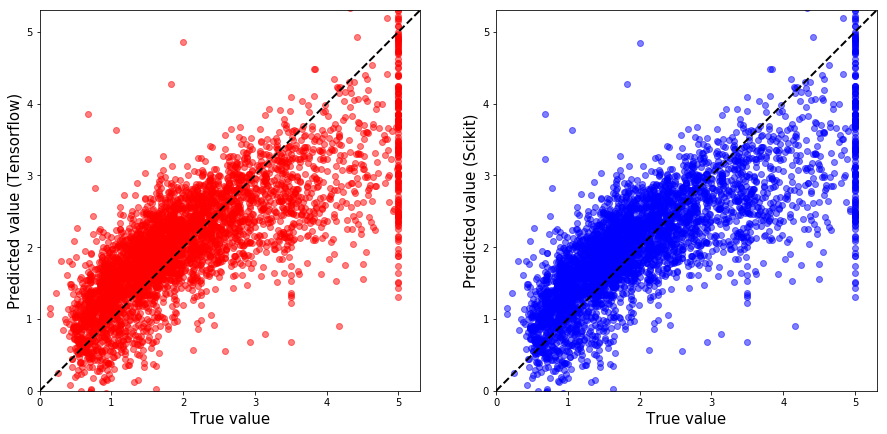

In [110]:
# For comparison perform linear regression with scikit learn
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression(fit_intercept=True, normalize=False).fit(train.features, train.target)

# plot
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax[0].plot(test.target, prediction_values, "o", color="red", alpha=.5)
ax[1].plot(test.target, lin_model.predict(test.features), "o", color="blue", alpha=.5)
for i in [0,1]:
    ax[i].plot([0,10], [0,10], "--", lw=2, color="black")
    ax[i].set_xlabel("True value",  fontsize=15)
    ax[i].set_ylim(0,5.3)
    ax[i].set_xlim(0,5.3)
ax[0].set_ylabel("Predicted value (Tensorflow)", fontsize=15);
ax[1].set_ylabel("Predicted value (Scikit)",  fontsize=15);

# Using functions
* The above code is ugly
* Rather we would like to put the graph construction in (a) function(s)

# Sharing variables via placeholders
# Name scopes

# Linear Regression via an optimizier 
* Assume that we could not find the minimizer analytically. 
* Thus we wish to find the minimzer computationally.